In [1]:
# Importing relevant modules
import pandas as pd
import geopandas as gpd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import math
import duckdb
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import scipy

# Data Sources

In [2]:
# Loading Data
IMD_accessibility_df = pd.read_csv("Data/London.csv")
print(IMD_accessibility_df.columns)

Index(['lsoa11cd', 'lsoa11nm', 'lsoa11nmw', 'st_areasha', 'st_lengths',
       'IMD_Rank', 'IMD_Decile', 'LSOA01NM', 'LADcd', 'LADnm', 'IMDScore',
       'IMDRank0', 'IMDDec0', 'IncScore', 'IncRank', 'IncDec', 'EmpScore',
       'EmpRank', 'EmpDec', 'EduScore', 'EduRank', 'EduDec', 'HDDScore',
       'HDDRank', 'HDDDec', 'CriScore', 'CriRank', 'CriDec', 'BHSScore',
       'BHSRank', 'BHSDec', 'EnvScore', 'EnvRank', 'EnvDec', 'IDCScore',
       'IDCRank', 'IDCDec', 'IDOScore', 'IDORank', 'IDODec', 'CYPScore',
       'CYPRank', 'CYPDec', 'ASScore', 'ASRank', 'ASDec', 'GBScore', 'GBRank',
       'GBDec', 'WBScore', 'WBRank', 'WBDec', 'IndScore', 'IndRank', 'IndDec',
       'OutScore', 'OutRank', 'OutDec', 'TotPop', 'DepChi', 'Pop16_59',
       'Pop60_', 'WorkPop', 'Shape__Are', 'Shape__Len',
       'SpatialSeparationAccessibility', 'Gravity_Accessibility',
       'Log_SpatialSeparation', 'Log_Gravity', 'Shape_Length', 'Shape_Area',
       'ReciprocalSpatialSeparation', 'IMD_Decile2',
    

In [3]:
# Loading Income Data
income_df = pd.read_csv("Data/modelled-household-income-estimates-oa-lsoa-msoa-ward-borough.csv")
income_df.head()

Code                 Name   LAD code         Borough  \
0  E01000001  City of London 001A  E09000001  City of London   
1  E01000002  City of London 001B  E09000001  City of London   
2  E01000003  City of London 001C  E09000001  City of London   
3  E01000005  City of London 001E  E09000001  City of London   
4  E01032739  City of London 001F  E09000001  City of London   

   Total Mean Annual Household Income estimate  \
0                                     74846.18   
1                                     73325.39   
2                                     44130.31   
3                                     30780.84   
4                                     68021.74   

   Total Median Annual Household Income estimate  
0                                       58347.32  
1                                       57159.50  
2                                       34386.56  
3                                       23999.85  
4                                       53017.04

In [4]:
lsoa_gdf = gpd.read_file("Data/Boundaries/LSOA_2011_London_gen_MHW.shp")
lsoa_gdf.head()

LSOA11CD                   LSOA11NM   MSOA11CD                  MSOA11NM  \
0  E01000001        City of London 001A  E02000001        City of London 001   
1  E01000002        City of London 001B  E02000001        City of London 001   
2  E01000003        City of London 001C  E02000001        City of London 001   
3  E01000005        City of London 001E  E02000001        City of London 001   
4  E01000006  Barking and Dagenham 016A  E02000017  Barking and Dagenham 016   

     LAD11CD               LAD11NM    RGN11CD RGN11NM  USUALRES  HHOLDRES  \
0  E09000001        City of London  E12000007  London      1465      1465   
1  E09000001        City of London  E12000007  London      1436      1436   
2  E09000001        City of London  E12000007  London      1346      1250   
3  E09000001        City of London  E12000007  London       985       985   
4  E09000002  Barking and Dagenham  E12000007  London      1703      1699   

   COMESTRES  POPDEN  HHOLDS  AVHHOLDSZ  \
0          0   112.9     876        1.7   
1          0    62.9     830        1.7   
2         96   227.7     817        1.5   
3          0    52.0     467        2.1   
4          4   116.2     543        3.1   

                                            geometry  
0  POLYGON ((532105.092 182011.230, 532162.491 18...  
1  POLYGON ((532746.813 181786.891, 532671.688 18...  
2  POLYGON ((532135.145 182198.119, 532158.250 18...  
3  POLYGON ((533807.946 180767.770, 533649.063 18...  
4  POLYGON ((545122.049 184314.931, 545271.917 18...

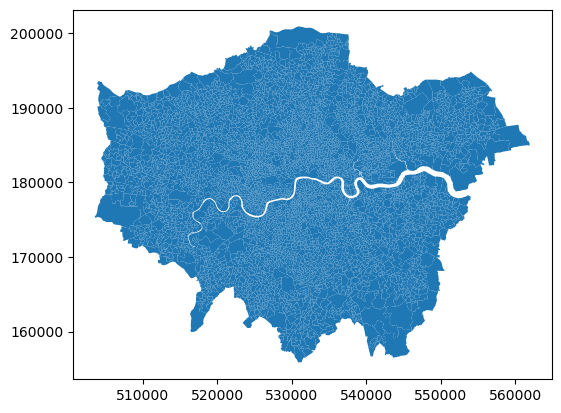

In [5]:
lsoa_gdf.plot();

# Data Cleaning

## Merging Datasets

In [7]:
gdf = lsoa_gdf.merge(IMD_accessibility_df, how='left', left_on='LSOA11CD', right_on='lsoa11cd')

In [8]:
gdf = gdf.merge(income_df, how='left', left_on='LSOA11CD', right_on='Code')
gdf.columns

Index(['LSOA11CD', 'LSOA11NM', 'MSOA11CD', 'MSOA11NM', 'LAD11CD', 'LAD11NM',
       'RGN11CD', 'RGN11NM', 'USUALRES', 'HHOLDRES', 'COMESTRES', 'POPDEN',
       'HHOLDS', 'AVHHOLDSZ', 'geometry', 'lsoa11cd', 'lsoa11nm', 'lsoa11nmw',
       'st_areasha', 'st_lengths', 'IMD_Rank', 'IMD_Decile', 'LSOA01NM',
       'LADcd', 'LADnm', 'IMDScore', 'IMDRank0', 'IMDDec0', 'IncScore',
       'IncRank', 'IncDec', 'EmpScore', 'EmpRank', 'EmpDec', 'EduScore',
       'EduRank', 'EduDec', 'HDDScore', 'HDDRank', 'HDDDec', 'CriScore',
       'CriRank', 'CriDec', 'BHSScore', 'BHSRank', 'BHSDec', 'EnvScore',
       'EnvRank', 'EnvDec', 'IDCScore', 'IDCRank', 'IDCDec', 'IDOScore',
       'IDORank', 'IDODec', 'CYPScore', 'CYPRank', 'CYPDec', 'ASScore',
       'ASRank', 'ASDec', 'GBScore', 'GBRank', 'GBDec', 'WBScore', 'WBRank',
       'WBDec', 'IndScore', 'IndRank', 'IndDec', 'OutScore', 'OutRank',
       'OutDec', 'TotPop', 'DepChi', 'Pop16_59', 'Pop60_', 'WorkPop',
       'Shape__Are', 'Shape__Len', 'Spat

In [9]:
gdf = gdf.drop(['lsoa11cd', 'lsoa11nm', 'lsoa11nmw', 
                'MSOA11CD', 'MSOA11NM', 'LAD11CD', 'LAD11NM',
                'RGN11CD', 'RGN11NM',
                'POPDEN',
                'st_areasha', 'st_lengths', 
                'Shape_Length', 'Shape_Area',
                'LSOA01NM', 'LADcd', 'LADnm', 
                'IMDRank0', 'IMDDec0', 'IMD_Decile2',
                'Code', 'Name', 'LAD code', 'Borough',
                'SpatialSeparationAccessibility',
                'Log_SpatialSeparation','ReciprocalSpatialSeparation'], axis=1)

gdf = gdf.rename(columns={'Total Mean Annual Household Income estimate':'Mean_Income',
                          'Total Median Annual Household Income estimate':'Median_Income',
                          'IMDScore': 'IMD',
                          'Gravity_Accessibility':'Accessibility',
                          'Log_Gravity':'log_Accessibility'})

print(gdf.columns)
gdf.head()

Index(['LSOA11CD', 'LSOA11NM', 'USUALRES', 'HHOLDRES', 'COMESTRES', 'HHOLDS',
       'AVHHOLDSZ', 'geometry', 'IMD_Rank', 'IMD_Decile', 'IMD', 'IncScore',
       'IncRank', 'IncDec', 'EmpScore', 'EmpRank', 'EmpDec', 'EduScore',
       'EduRank', 'EduDec', 'HDDScore', 'HDDRank', 'HDDDec', 'CriScore',
       'CriRank', 'CriDec', 'BHSScore', 'BHSRank', 'BHSDec', 'EnvScore',
       'EnvRank', 'EnvDec', 'IDCScore', 'IDCRank', 'IDCDec', 'IDOScore',
       'IDORank', 'IDODec', 'CYPScore', 'CYPRank', 'CYPDec', 'ASScore',
       'ASRank', 'ASDec', 'GBScore', 'GBRank', 'GBDec', 'WBScore', 'WBRank',
       'WBDec', 'IndScore', 'IndRank', 'IndDec', 'OutScore', 'OutRank',
       'OutDec', 'TotPop', 'DepChi', 'Pop16_59', 'Pop60_', 'WorkPop',
       'Shape__Are', 'Shape__Len', 'Accessibility', 'log_Accessibility',
       'Gravity_Accessibility_Decile', 'Pop_Den', 'Mean_Income',
       'Median_Income'],
      dtype='object')


LSOA11CD                   LSOA11NM  USUALRES  HHOLDRES  COMESTRES  \
0  E01000001        City of London 001A      1465      1465          0   
1  E01000002        City of London 001B      1436      1436          0   
2  E01000003        City of London 001C      1346      1250         96   
3  E01000005        City of London 001E       985       985          0   
4  E01000006  Barking and Dagenham 016A      1703      1699          4   

   HHOLDS  AVHHOLDSZ                                           geometry  \
0     876        1.7  POLYGON ((532105.092 182011.230, 532162.491 18...   
1     830        1.7  POLYGON ((532746.813 181786.891, 532671.688 18...   
2     817        1.5  POLYGON ((532135.145 182198.119, 532158.250 18...   
3     467        2.1  POLYGON ((533807.946 180767.770, 533649.063 18...   
4     543        3.1  POLYGON ((545122.049 184314.931, 545271.917 18...   

   IMD_Rank  IMD_Decile  ...  Pop60_  WorkPop   Shape__Are   Shape__Len  \
0   29199.0         9.0  ...   465.0   715.00  343907.4198  3682.439420   
1   30379.0        10.0  ...   394.0   619.75  583474.0418  3910.387240   
2   14915.0         5.0  ...   445.0   804.00  147839.5061  1834.931320   
3    8678.0         3.0  ...   200.0   683.00  491918.0930  3483.179208   
4   14486.0         5.0  ...   221.0  1284.50  372257.3212  3108.610781   

   Accessibility  log_Accessibility  Gravity_Accessibility_Decile  \
0     276.287828           5.621443                          10.0   
1     633.584111           6.451393                          10.0   
2      17.670438           2.871893                          10.0   
3     396.246802           5.982037                          10.0   
4       0.887237          -0.119643                           1.0   

       Pop_Den  Mean_Income  Median_Income  
0  3768.456059     74846.18       58347.32  
1  1981.236383     73325.39       57159.50  
2  9131.524014     44130.31       34386.56  
3  2278.834659     30780.84       23999.85  
4  5480.080267     46141.12       39140.64  

[5 rows x 69 columns]

## Applying Transformations

In [10]:
gdf['sqrt_IMD']=np.sqrt(gdf['IMD'])
gdf['log_Median_Income']=np.log(gdf['Median_Income'])
gdf['log_Mean_Income']=np.log(gdf['Mean_Income'])
gdf['cbrt_Pop_Den']=np.cbrt(gdf['Pop_Den'])

df.head()

lsoa11cd      lsoa11nm     IMD  Income_IMD  Accessibility  \
0  E01000816  Bromley 040A  14.081       0.084       0.151895   
1  E01000818  Bromley 040B  13.454       0.066       0.796410   
2  E01000819  Bromley 040C  26.536       0.194       4.194092   
3  E01000820  Bromley 008C  21.127       0.138       4.019887   
4  E01000822  Bromley 008D  13.278       0.102       2.578399   

   log_Accessibility      Pop_Den  Mean_Income  Median_Income  
0          -1.884566  1917.563663     44130.75       34008.31  
1          -0.227641   457.080908     51429.54       39633.12  
2           1.433677  1695.616931     36413.83       28064.70  
3           1.391254  1001.671812     48961.52       37730.45  
4           0.947169  3038.684037     46492.50       35827.34

Skewness: [nan nan]


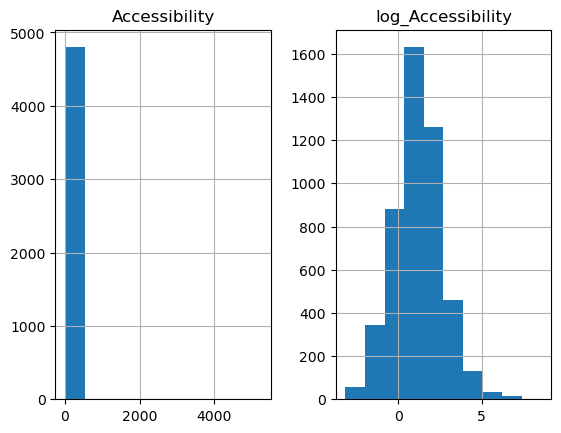

In [11]:
gdf[['Accessibility','log_Accessibility']].hist()
print("Skewness:", scipy.stats.skew(gdf[['Accessibility','log_Accessibility']]))

Skewness: [nan nan]


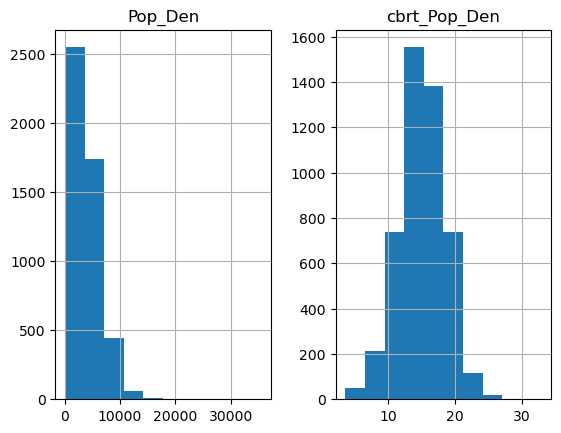

In [12]:
gdf[['Pop_Den','cbrt_Pop_Den']].hist()
print("Skewness:", scipy.stats.skew(gdf[['Pop_Den','cbrt_Pop_Den']]))

Skewness: [nan nan]


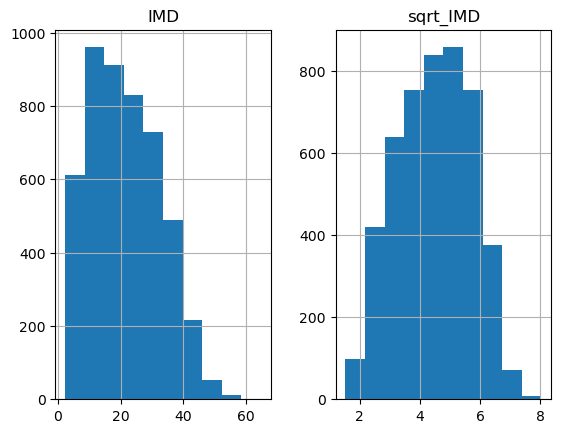

In [13]:
gdf[['IMD','sqrt_IMD']].hist()
print("Skewness:", scipy.stats.skew(gdf[['IMD','sqrt_IMD']]))

Skewness: [1.35592993 0.55727179 1.09746997 0.46070606]


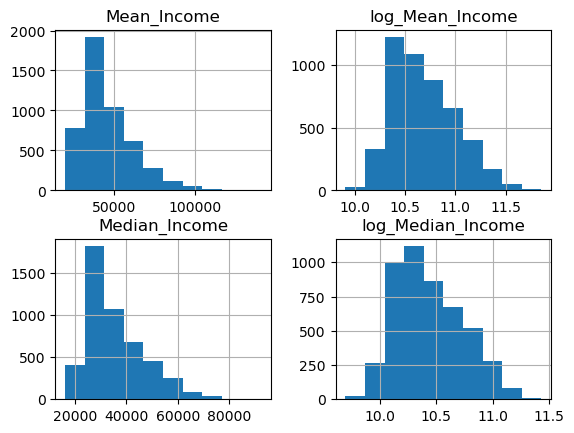

In [14]:
gdf[['Mean_Income','log_Mean_Income','Median_Income','log_']].hist()
print("Skewness:", scipy.stats.skew(gdf[['Mean_Income','log_Mean_Income','Median_Income','log_Median_Income']]))

# Exploratory Data Analysis

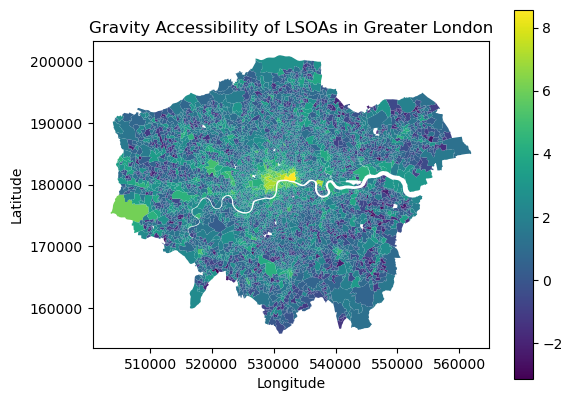

In [43]:
ax = gdf.plot(column='log_Accessibility', legend=True);
ax.set(title='Gravity Accessibility of LSOAs in Greater London',
       xlabel='Longitude',ylabel='Latitude');

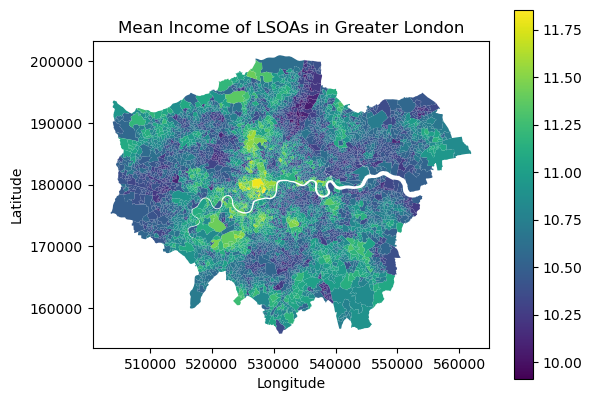

In [29]:
ax = gdf.plot(column='log_Mean_Income', legend=True);
ax.set(title='Mean Income of LSOAs in Greater London',xlabel='Longitude',ylabel='Latitude');

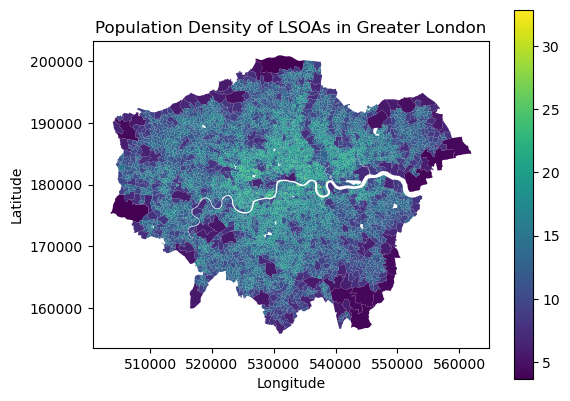

In [30]:
ax = gdf.plot(column='cbrt_Pop_Den', legend=True);
ax.set(title='Population Density of LSOAs in Greater London',xlabel='Longitude',ylabel='Latitude');

Text(0.5, 1.05, 'Bivariate KDE plot of accessibility and deprivation')

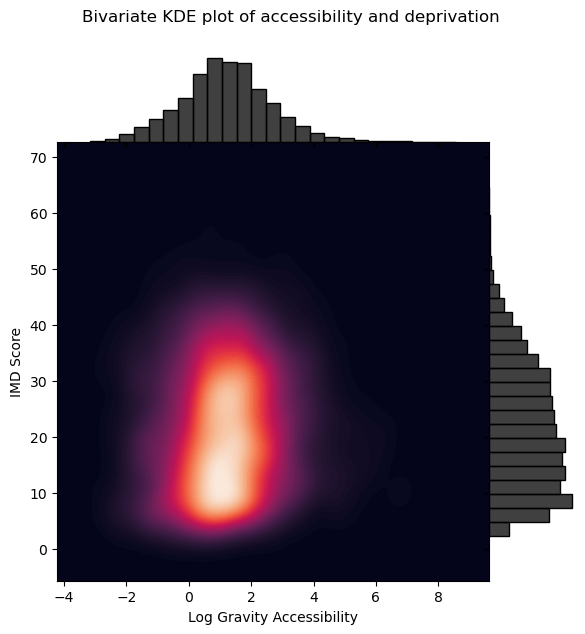

In [52]:
joined_plot = sns.JointGrid(data=gdf, 
                            x='log_Accessibility', y='IMD', 
                            space=0)
joined_plot.plot_joint(sns.kdeplot,fill=True,
                       thresh=0, levels=100, cmap="rocket")
joined_plot.set_axis_labels(xlabel='Log Gravity Accessibility',
                            ylabel='IMD Score')
joined_plot.plot_marginals(sns.histplot, bins=25, color='black')

plt.suptitle("Bivariate KDE plot of accessibility and deprivation",
             y=1.05)

In [45]:
gdf[['log_Accessibility','cbrt_Pop_Den', 'sqrt_IMD']].corr()

log_Accessibility  cbrt_Pop_Den  sqrt_IMD
log_Accessibility           1.000000     -0.009102  0.071422
cbrt_Pop_Den               -0.009102      1.000000  0.342775
sqrt_IMD                    0.071422      0.342775  1.000000

# Regression Model

In [15]:
reg_df = gdf.drop(['geometry'], axis=1).dropna()

In [16]:
# Mean centering
reg_df['log_Accessibility_mean_centered'] = reg_df['log_Accessibility'] - reg_df['log_Accessibility'].mean()
reg_df['cbrt_Pop_Den_mean_centered'] = reg_df['cbrt_Pop_Den'] - reg_df['cbrt_Pop_Den'].mean()

In [17]:
# Interaction term
reg_df['interaction']=reg_df['log_Accessibility_mean_centered']*reg_df['cbrt_Pop_Den_mean_centered']

In [18]:
reg_df[['log_Accessibility_mean_centered','cbrt_Pop_Den_mean_centered', 'interaction', 'sqrt_IMD']].corr()

log_Accessibility_mean_centered  \
log_Accessibility_mean_centered                         1.000000   
cbrt_Pop_Den_mean_centered                             -0.009102   
interaction                                            -0.128735   
sqrt_IMD                                                0.071422   

                                 cbrt_Pop_Den_mean_centered  interaction  \
log_Accessibility_mean_centered                   -0.009102    -0.128735   
cbrt_Pop_Den_mean_centered                         1.000000     0.106490   
interaction                                        0.106490     1.000000   
sqrt_IMD                                           0.342775    -0.138936   

                                 sqrt_IMD  
log_Accessibility_mean_centered  0.071422  
cbrt_Pop_Den_mean_centered       0.342775  
interaction                     -0.138936  
sqrt_IMD                         1.000000

In [19]:
X = reg_df[['log_Accessibility_mean_centered','cbrt_Pop_Den_mean_centered','interaction']]
y = reg_df['sqrt_IMD']
X = sm.add_constant(X)

sm_model = sm.OLS(y, X)
res = sm_model.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:               sqrt_IMD   R-squared:                       0.151
Model:                            OLS   Adj. R-squared:                  0.151
Method:                 Least Squares   F-statistic:                     286.0
Date:                Fri, 03 Nov 2023   Prob (F-statistic):          8.14e-171
Time:                        18:40:57   Log-Likelihood:                -7390.0
No. Observations:                4814   AIC:                         1.479e+04
Df Residuals:                    4810   BIC:                         1.481e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     